<a href="https://colab.research.google.com/github/bibekyess/AI_practice/blob/main/Killionaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
# Importing necessary libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os


In [177]:
# Gets the data
!wget https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/BTC_updated.csv

--2022-06-16 05:30:32--  https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/BTC_updated.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185302 (181K) [text/plain]
Saving to: ‘BTC_updated.csv.1’

BTC_updated.csv.1   100%[===================>] 180.96K  --.-KB/s    in 0.02s   

2022-06-16 05:30:33 (7.25 MB/s) - ‘BTC_updated.csv.1’ saved [185302/185302]



In [178]:
"""
  Creates a bitcoin dataframe
"""
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_updated.csv", parse_dates=["Date"])
df.rename(columns = {"Close": "Price", "Date": "Timestamp"}, inplace = True)
df.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
# df['Timestamp'] = pd.to_datetime(df['Date'].dt.date)
btc_df = df.set_index('Timestamp')
btc_df.head(), btc_df.tail()

(                 Price
 Timestamp             
 2014-09-17  457.334015
 2014-09-18  424.440002
 2014-09-19  394.795990
 2014-09-20  408.903992
 2014-09-21  398.821014,                   Price
 Timestamp              
 2022-06-01  29799.08008
 2022-06-02  30467.48828
 2022-06-03  29704.39063
 2022-06-04  29832.91406
 2022-06-05  30006.00391)

In [179]:
# Makes a copy before normalizing price values
btc_df_original_uni = btc_df.copy()

In [180]:
price_mem_univariate = {}
price_mem_multivariate = {}
def normalize(df, price_mem):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        if (feature_name=='Price'):
          price_mem["min_value"] = min_value
          price_mem["max_value"] = max_value
    return result


In [181]:
# def denormalize_price(result, price_mem):
#   final_price = []
#   mean = price_mem.get("mean")
#   var = price_mem.get("var")
#   for i in result:
#     price_ = i * (max_value - min_value) + min_value
#     final_price.append(price_)
#   return final_price

In [182]:
# Normalizing the dataframe
btc_df = normalize(btc_df, price_mem_univariate)

In [183]:
price_mem_univariate

{'max_value': 67566.82813, 'min_value': 178.102997}

In [184]:
btc_df_original_uni.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2819 entries, 2014-09-17 to 2022-06-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2819 non-null   float64
dtypes: float64(1)
memory usage: 44.0 KB


In [185]:
# Displays the distribution of dataset
btc_df_original_uni.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,2819.0,12326.049125,16632.441546,178.102997,623.742981,6499.27002,11356.062985,67566.82813


In [186]:
btc_df_original_uni

,Price
Timestamp,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2022-06-01,29799.080080
2022-06-02,30467.488280
2022-06-03,29704.390630


In [187]:
btc_df_original_uni.columns

Index(['Price'], dtype='object')

In [188]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(btc_df_original_uni), index = btc_df_original_uni.index, columns = btc_df_original_uni.columns)
# df_scaled

In [189]:
# scaler.inverse_transform(np.array([-0.713715]).reshape(-1,1))

In [190]:
# df_test = pd.DataFrame(scaler.inverse_transform(df_scaled), index = df_scaled.index, columns = df_scaled.columns)
# df_test

In [191]:
# Y_train

In [192]:
# Y_train.mean()

In [193]:
# Y_train.std()

In [194]:
from sklearn.preprocessing import StandardScaler
# For standardizing the data
scaler_1 = StandardScaler()

# Makes training, validation and test datasets
timesteps = btc_df.index.to_numpy()
prices = btc_df["Price"].to_numpy()

# 80% train, 20% test
boundary1 = int(0.8 * len(timesteps))

X_train, Y_train = timesteps[:boundary1], scaler_1.fit_transform(prices[:boundary1].reshape(-1,1))
X_test, Y_test = timesteps[boundary1:], scaler_1.transform(prices[boundary1:].reshape(-1,1))
Y_train = np.squeeze(Y_train, axis=1)
Y_test = np.squeeze(Y_test, axis=1)

len(X_train), len(X_test), len(Y_train), len(Y_test)

(2255, 564, 2255, 564)

In [195]:
scaler_1.transform(Y_test.reshape(-1,1))[0]

array([46.75491617])

In [196]:
Y_test[0]

3.0580702265090802

In [197]:
scaler_1.mean_

array([0.06605277])

In [198]:
scaler_1.var_

array([0.00409519])

In [199]:
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None, xlabel='Timestamp', ylabel='Price'): 
  # for format, we can go with '.' or '-' [scatter or line] and start means offset
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

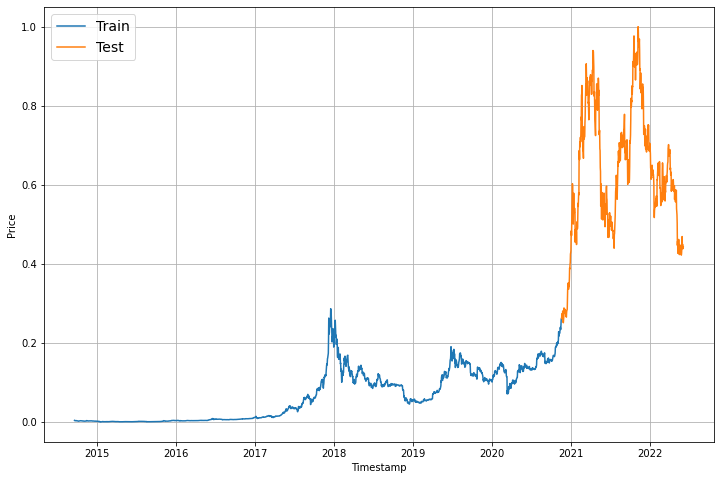

In [200]:
plt.figure(figsize=(12,8)) # Creates a figure and adds the following plot to it
plot_time_series(X_train, scaler_1.inverse_transform(Y_train.reshape(-1,1)), label= "Train")
plot_time_series(X_test, scaler_1.inverse_transform(Y_test.reshape(-1,1)), label = "Test")
# It would be interesting to put start and end as the year

Naive baseline model:
$\hat{y}_{t} = y_{t-1}$

In [201]:
naive_forecast = Y_test[:-1] # Gets every value excluding the last value

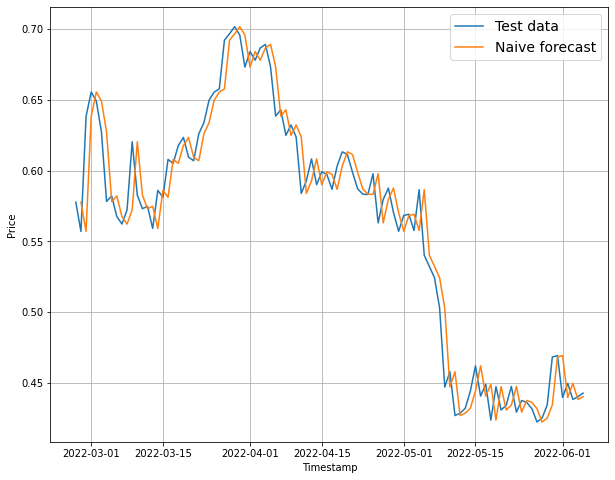

In [202]:
# Comparing naive_forecast with the test data
plt.figure(figsize=(10, 8))
offset = len(X_test)-100
plot_time_series(timesteps=X_test, values=scaler_1.inverse_transform(Y_test.reshape(-1,1)), start = offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=scaler_1.inverse_transform(naive_forecast.reshape(-1,1)), start = offset, format="-", label="Naive forecast");

In [203]:
"""
  returns error metrics in dictionary form
"""
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # better to use the numpy version of these too
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts an emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
  return_dict =  {
                  "mae": mae.numpy(),
                  "mse": mse.numpy(),
                  "rmse": rmse.numpy(),
                  "mape": mape.numpy(),
                  }
  return return_dict


In [204]:
naive_results = evaluate_preds(y_true=Y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 0.28652942, 'mape': 3.328375, 'mse': 0.15543115, 'rmse': 0.3942476}

In [205]:
"""
  Windowing a dataset, our plan is to predict a price for 1 day
  The following values uses 7 day data to predict 1 day price
"""
HORIZON = 1
WINDOW_SIZE = 7 # We will get this value by hyperparameter tuning later on.


In [206]:
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [207]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    makes windows using numpy arrays' indexing
    returns 2D array of sequential windows of window size
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # -1 to prevent window going off the last value

    # Here window_indexes gives the position of the value of respective indexes, so using x[window_indexes] puts the respective x values in the position
    # specified in the window_indexes. It only works with numpy arrays
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)
    return windows, labels


In [208]:
len(X_train)

2255

In [209]:
"""
  Makes training, validation and test datasets in windows
  80% train, 20% test
"""
boundary1 = int(0.8 * len(timesteps))
prices_train = Y_train

prices_test = Y_test

len(prices_train), len(prices_test)

(2255, 564)

In [210]:
mean = prices_train.mean()
prices_train.std(), mean

(1.0, 5.0415449100494913e-17)

In [211]:
train_windows, train_labels = make_windows(prices_train, WINDOW_SIZE, HORIZON)
test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )
len(train_windows), len(test_windows)

(2248, 557)

In [212]:
"""
  Since we are comparing different model's performance, it is better to compare each model's best performance with another model's best
  Model's performance is going to fluctuate epoch to epoch
  Create a function to implement a ModelCheckpoint callback with a specific filename 
"""

def create_model_checkpoint(model_name, save_path="models"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0, # elsewise continously printout if saved or not
                                            save_best_only=True)

In [213]:
def early_stopping(): 
  return tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=40,
                                          restore_best_weights=True)

## Finetuning the hyperparameters
First, with a simple dense model, lets try to find out a good value for WINDOW_SIZE and batch_size

In [214]:
# for i in range(1, 61):
#   WINDOW_SIZE = i

#   # Make windowed data with appropriate horizon and window sizes
#   train_windows, train_labels = make_windows(prices_train, WINDOW_SIZE, HORIZON)
#   test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )

#   tf.random.set_seed(42)
#   model_2 = tf.keras.Sequential([
#       layers.Dense(128, activation="relu"),
#       layers.Dense(HORIZON, activation="relu")
#   ], name="fine_tuning_window_"+str(i))

#   model_2.compile(loss='mae',
#                   optimizer=tf.keras.optimizers.Adam())

#   model_2.fit(train_windows,
#               train_labels,
#               epochs=100,
#               batch_size=512,
#               verbose=0,
#               validation_data=(test_windows, test_labels),
#               callbacks=[create_model_checkpoint(model_name=model_2.name)])


In [215]:
# min_loss = -1
# WINDOW_SIZE_N = 1
# for i in range(1, 61):
#   WINDOW_SIZE = i
#   test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )
#   model = tf.keras.models.load_model("models/fine_tuning_window_" + str(i))
#   loss = model.evaluate(test_windows, test_labels)
#   if (min_loss>loss): 
#     min_loss=loss
#     WINDOW_SIZE_N = i
#   elif (min_loss == -1): 
#     min_loss = loss
#     WINDOW_SIZE_N = i
# model_name = "models/fine_tuning_window_" + str(WINDOW_SIZE_N)
# WINDOW_SIZE = WINDOW_SIZE_N
# model_name, min_loss

In [216]:
WINDOW_SIZE = 6

In [217]:
len(prices_train), len(prices_test)

(2255, 564)

In [218]:
train_windows, train_labels = make_windows(prices_train, WINDOW_SIZE, HORIZON)
test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )

**For batch_size**

In [219]:
# # Make windowed data with appropriate horizon and window sizes

# batch_sizes = [32, 64, 128, 256, 512, 1024]

# for i in batch_sizes:
#   tf.random.set_seed(42)
#   model_tuning = tf.keras.Sequential([
#       layers.Dense(128, activation="relu"),
#       layers.Dense(HORIZON, activation="relu")
#   ], name="fine_tuning_batch_size_"+str(i))

#   model_tuning.compile(loss='mae',
#                   optimizer=tf.keras.optimizers.Adam())

#   model_tuning.fit(train_windows,
#               train_labels,
#               epochs=100,
#               batch_size=i,
#               verbose=0,
#               validation_data=(test_windows, test_labels),
#               callbacks=[create_model_checkpoint(model_name=model_tuning.name)])


In [220]:
# min_loss = -1
# BATCH_SIZE = 0
# for i in batch_sizes:
#   model = tf.keras.models.load_model("models/fine_tuning_batch_size_" + str(i))
#   loss = model.evaluate(test_windows, test_labels)
#   if (min_loss>loss): 
#     min_loss=loss
#     BATCH_SIZE = i  
#   elif (min_loss == -1): 
#     min_loss=loss
#     BATCH_SIZE = i  

# model_name = "models/fine_tuning_batch_size_" + str(BATCH_SIZE)

# model_name, min_loss

In [221]:
BATCH_SIZE = 64

In [222]:
print("Window size is: ", WINDOW_SIZE)
print("Batch size is: ", BATCH_SIZE)

Window size is:  6
Batch size is:  64


In [223]:
""" 
  Model-1: Dense model (window=7, horizon=1)
"""

# Set random seed for as reprodicible results as possible
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation='relu'),
  layers.Dense(HORIZON, activation='relu')
], name='model_dense') # we can use it for our checkpoint function

# 2. Compile
model_1.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=1000,
            verbose=1, # it refers to how much information we want to print for our models
            batch_size=BATCH_SIZE,
            validation_data=(test_windows, test_labels),
            callbacks=[early_stopping()])



Epoch 1/1000
36/36 [==============================] - 1s 7ms/step - loss: 0.5822 - mae: 0.5822 - mse: 0.5380 - val_loss: 0.8879 - val_mae: 0.8879 - val_mse: 1.1055
Epoch 2/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.4883 - mae: 0.4883 - mse: 0.4158 - val_loss: 0.4997 - val_mae: 0.4997 - val_mse: 0.4147
Epoch 3/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.4842 - mae: 0.4842 - mse: 0.4142 - val_loss: 0.4384 - val_mae: 0.4384 - val_mse: 0.3198
Epoch 4/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.4809 - mae: 0.4809 - mse: 0.4131 - val_loss: 0.4104 - val_mae: 0.4104 - val_mse: 0.2832
Epoch 5/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.4780 - mae: 0.4780 - mse: 0.4121 - val_loss: 0.4162 - val_mae: 0.4162 - val_mse: 0.2864
Epoch 6/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.4769 - mae: 0.4769 - mse: 0.4116 - val_loss: 0.3593 - val_mae: 0.3593 - val_mse: 0.2251
Epoch 7/1000
36/

In [224]:
# Evaluates on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 7ms/step - loss: 0.2877 - mae: 0.2877 - mse: 0.1575


[0.28770750761032104, 0.28770750761032104, 0.1574787199497223]

In [225]:
## After evaluating the model, lets forecast using the model (it is pseudo forecast)
def make_prediction(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # Squeezing is needed because we are returning 1D array of predictions

In [226]:
# Make predictions using model_dense on the test dataset and evaluate it on test data
model_1_prediction = make_prediction(model_1, test_windows)

In [227]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_prediction)
model_1_results

{'mae': 0.28770754, 'mape': 3.3298557, 'mse': 0.15747869, 'rmse': 0.39683583}

In [228]:
X_test.shape

(564,)

In [229]:
test_labels[:, 0].shape

(558,)

In [230]:
# model_1_prediction.numpy()

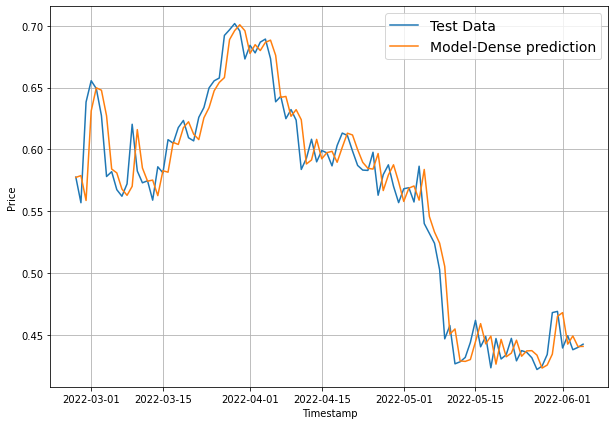

In [231]:
# Plotting model-1 predictions
plt.figure(figsize=(10,7))
offset=len(test_windows)-100
plot_time_series(timesteps=X_test[-len(test_windows):], values=scaler_1.inverse_transform(test_labels[:, 0].reshape(-1,1)), start=offset, label='Test Data', format="-")
plot_time_series(timesteps=X_test[-len(test_windows):], values=scaler_1.inverse_transform(model_1_prediction.numpy().reshape(-1,1)), start=offset, label="Model-Dense prediction", format='-')

### Model-2 CNN

In [244]:
tf.random.set_seed(42)

# Create Conv1D model
model_2 = tf.keras.Sequential([

  layers.Lambda(lambda k: tf.expand_dims(k, axis=1)), # firstly adjust the size of our input data
  
  layers.Conv1D(filters=256, kernel_size=8, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  # layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  # layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  layers.GlobalAveragePooling1D(),
  # layers.Dense(128, activation='relu'),
  layers.Dense(HORIZON, activation="relu")

], name="model_conv1D")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mape"])

# Fit model
history_model_2 = model_2.fit(train_windows,
            train_labels, 
            batch_size=BATCH_SIZE, 
            epochs=1000, 
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[early_stopping()]
            )

Epoch 1/1000
36/36 [==============================] - 1s 15ms/step - loss: 0.5743 - mae: 0.5743 - mape: 72.8643 - val_loss: 1.2522 - val_mae: 1.2522 - val_mape: 13.7554
Epoch 2/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.4899 - mae: 0.4899 - mape: 64.0750 - val_loss: 0.4734 - val_mae: 0.4734 - val_mape: 5.4939
Epoch 3/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.4853 - mae: 0.4853 - mape: 62.7173 - val_loss: 0.4384 - val_mae: 0.4384 - val_mape: 4.9952
Epoch 4/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.4815 - mae: 0.4815 - mape: 62.0130 - val_loss: 0.3986 - val_mae: 0.3986 - val_mape: 4.5570
Epoch 5/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.4784 - mae: 0.4784 - mape: 61.3871 - val_loss: 0.4024 - val_mae: 0.4024 - val_mape: 4.5508
Epoch 6/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.4767 - mae: 0.4767 - mape: 60.9014 - val_loss: 0.3443 - val_mae: 0.3443 - val_mape: 3.9

In [245]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 0.2891 - mae: 0.2891 - mape: 3.3437


[0.2890565097332001, 0.2890565097332001, 3.343696117401123]

In [246]:
history_model_2.history.keys()

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])

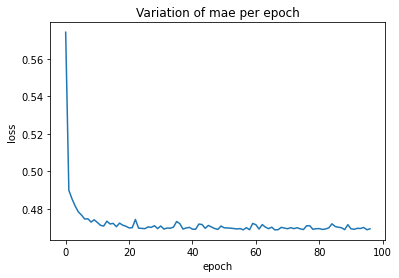

In [247]:
plt.plot(history_model_2.history['mae'])
plt.title('Variation of mae per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

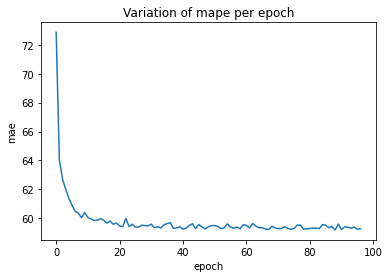

In [301]:
plt.plot(history_model_2.history['mape'])
plt.title('Variation of mape per epoch')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

In [60]:
# Model predictions
model_2_preds = make_prediction(model_2, test_windows)

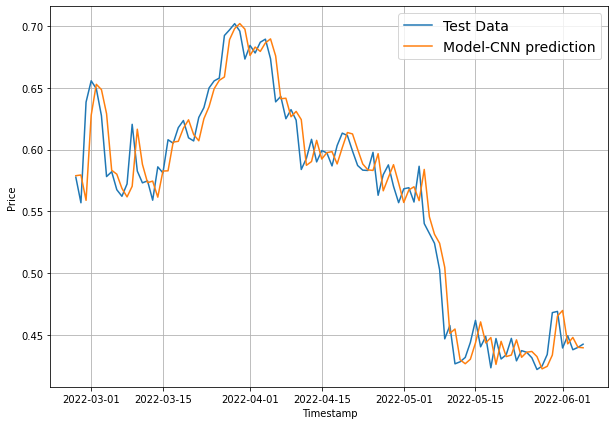

In [61]:
offset=len(test_windows)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=scaler_1.inverse_transform(test_labels[:, 0].reshape(-1,1)), start=offset, label='Test Data', format="-")
plot_time_series(timesteps=X_test[-len(test_windows):], values=scaler_1.inverse_transform(model_2_preds.numpy().reshape(-1,1)), start=offset, label="Model-CNN prediction", format='-')

In [62]:
# Evaluate predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': 0.28905645, 'mape': 3.3436959, 'mse': 0.15816058, 'rmse': 0.39769408}

In [63]:
model_2.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 6)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 256)            12544     
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
_________________________________________________________________


# Model 3: RNN (LSTM)

In [249]:
# See improving a model section of the bit-predict notebook
tf.random.set_seed(42)

# Make an LSTM model with the functional API
inputs=layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x) # to create more than 1 hidden layer
x = layers.Bidirectional(layers.LSTM(512, activation="relu"))(x)
# x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
history_model_3 = model_3.fit(train_windows,
            train_labels,
            epochs=1000,
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_data=(test_windows, test_labels),
            callbacks=[early_stopping()]
            )



Epoch 1/1000
36/36 [==============================] - 5s 40ms/step - loss: 0.3402 - val_loss: 3.8032
Epoch 2/1000
36/36 [==============================] - 1s 25ms/step - loss: 0.0609 - val_loss: 4.4990
Epoch 3/1000
36/36 [==============================] - 1s 26ms/step - loss: 0.0523 - val_loss: 3.1909
Epoch 4/1000
36/36 [==============================] - 1s 29ms/step - loss: 0.0480 - val_loss: 3.4994
Epoch 5/1000
36/36 [==============================] - 1s 28ms/step - loss: 0.0449 - val_loss: 2.6380
Epoch 6/1000
36/36 [==============================] - 1s 23ms/step - loss: 0.0425 - val_loss: 2.2163
Epoch 7/1000
36/36 [==============================] - 1s 17ms/step - loss: 0.0387 - val_loss: 1.7014
Epoch 8/1000
36/36 [==============================] - 1s 20ms/step - loss: 0.0422 - val_loss: 0.9926
Epoch 9/1000
36/36 [==============================] - 1s 15ms/step - loss: 0.0383 - val_loss: 1.6736
Epoch 10/1000
36/36 [==============================] - 1s 29ms/step - loss: 0.0412 - val_lo

In [250]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 0.2979


0.2979489266872406

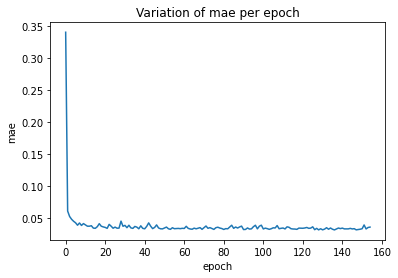

In [300]:
plt.plot(history_model_3.history['loss'])
plt.title('Variation of mae per epoch')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

In [67]:
# Make predictions with our LSTM model
model_3_preds = make_prediction(model_3, test_windows)

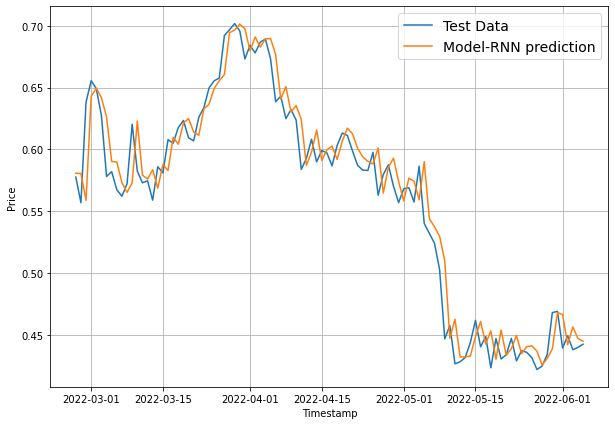

In [68]:
offset=len(test_windows)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=scaler_1.inverse_transform(test_labels[:, 0].reshape(-1,1)), start=offset, label='Test Data', format="-")
plot_time_series(timesteps=X_test[-len(test_windows):], values=scaler_1.inverse_transform(model_3_preds.numpy().reshape(-1,1)), start=offset, label="Model-RNN prediction", format='-')

In [69]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': 0.296405, 'mape': 3.4301329, 'mse': 0.16271201, 'rmse': 0.40337574}

## Multivariate Models

In [253]:
"""
  Creates a bitcoin dataframe
"""
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_updated.csv", parse_dates=["Date"])
df.rename(columns = {"Close": "Price", "Date": "Timestamp"}, inplace = True)
btc_df = df.set_index('Timestamp')
btc_df.head(), btc_df.tail()

(                  Open        High         Low       Price      Volume
 Timestamp                                                             
 2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800.0
 2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200.0
 2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700.0
 2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600.0
 2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100.0,
                    Open         High          Low        Price        Volume
 Timestamp                                                                   
 2022-06-01  31792.55469  31957.28516  29501.58789  29799.08008  4.113582e+10
 2022-06-02  29794.89063  30604.73438  29652.70508  30467.48828  2.908356e+10
 2022-06-03  30467.80664  30633.03516  29375.68945  29704.39063  2.617555e+10
 2022-06-04  29706.13867  29930.56445  29500.00586  29832.91406  1.658837e+10
 2022-06-05  29836.29297  3

In [254]:
# 80% train, 15% test
boundary = int(0.8 * len(btc_df))
btc_df_train, btc_df_test = btc_df[:boundary], btc_df[boundary:]
len(btc_df_train), len(btc_df_test)

(2255, 564)

In [255]:
scaler_2 = StandardScaler()
btc_df_train = pd.DataFrame(scaler_2.fit_transform(btc_df_train), index = btc_df_train.index, columns = btc_df_train.columns)
btc_df_test = pd.DataFrame(scaler_2.transform(btc_df_test), index = btc_df_test.index, columns = btc_df_test.columns)

In [256]:
import math
def denormalize_price(result):
  final_price = []
  mean = scaler_2.mean_[3]
  std = math.sqrt(scaler_2.var_[3])
  for i in result:
    price_ = i * std + mean
    final_price.append(price_)
  return final_price

In [257]:
#  Windows the dataset directly from the pandas dataframe
"""
  [0,1,2,3,4,5,6,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low] -> [7]
  [1,2,3,4,5,6,7,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low] -> [8]
"""
btc_windowed_df_train = btc_df_train.copy() # copy is needed to avoid pandas warning
btc_windowed_df_test = btc_df_test.copy()

# Adds windowed columns
for i in range(WINDOW_SIZE):
  btc_windowed_df_train[f"Price+{i+1}"] = btc_df_train["Price"].shift(periods=i+1)
for i in range(WINDOW_SIZE):
  btc_windowed_df_test[f"Price+{i+1}"] = btc_df_test["Price"].shift(periods=i+1)
btc_windowed_df_train.head(10)

,Open,High,Low,Price,Volume,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6
Timestamp,,,,,,,,,,,
2014-09-17,-0.965501,-0.964501,-0.970753,-0.967427,-0.694870,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,-0.967593,-0.967057,-0.980180,-0.975055,-0.693794,-0.967427,NaN,NaN,NaN,NaN,NaN
2014-09-19,-0.975203,-0.973615,-0.987030,-0.981929,-0.693519,-0.975055,-0.967427,NaN,NaN,NaN,NaN
2014-09-20,-0.982040,-0.974640,-0.985747,-0.978657,-0.693603,-0.981929,-0.975055,-0.967427,NaN,NaN,NaN
2014-09-21,-0.978924,-0.977096,-0.984957,-0.980995,-0.694427,-0.978657,-0.981929,-0.975055,-0.967427,NaN,NaN
2014-09-22,-0.981012,-0.978341,-0.984010,-0.980223,-0.694624,-0.980995,-0.978657,-0.981929,-0.975055,-0.967427,NaN
2014-09-23,-0.980317,-0.970515,-0.984234,-0.972423,-0.692943,-0.980223,-0.980995,-0.978657,-0.981929,-0.975055,-0.967427
2014-09-24,-0.972497,-0.971745,-0.978255,-0.975341,-0.694103,-0.972423,-0.980223,-0.980995,-0.978657,-0.981929,-0.975055
2014-09-25,-0.975423,-0.974590,-0.981052,-0.978038,-0.694408,-0.975341,-0.972423,-0.980223,-0.980995,-0.978657,-0.981929


In [258]:
btc_windowed_df_train = btc_windowed_df_train.dropna()
btc_windowed_df_test = btc_windowed_df_test.dropna()

In [259]:
# Removing the rows with the missing values
# Create X (windows) and Y (horizons) features

x_train = btc_windowed_df_train.drop("Price", axis=1).astype(np.float32) # windows
y_train = btc_windowed_df_train["Price"].astype(np.float32) # labels
x_test = btc_windowed_df_test.drop("Price", axis=1).astype(np.float32) # windows
y_test = btc_windowed_df_test["Price"].astype(np.float32) # labels
len(x_train), len(x_test)

(2249, 558)

In [260]:
x_train

,Open,High,Low,Volume,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6
Timestamp,,,,,,,,,,
2014-09-23,-0.980317,-0.970515,-0.984234,-0.692943,-0.980223,-0.980995,-0.978657,-0.981929,-0.975055,-0.967427
2014-09-24,-0.972497,-0.971745,-0.978255,-0.694103,-0.972423,-0.980223,-0.980995,-0.978657,-0.981929,-0.975055
2014-09-25,-0.975423,-0.974590,-0.981052,-0.694408,-0.975341,-0.972423,-0.980223,-0.980995,-0.978657,-0.981929
2014-09-26,-0.978148,-0.976529,-0.983320,-0.694837,-0.978038,-0.975341,-0.972423,-0.980223,-0.980995,-0.978657
2014-09-27,-0.979977,-0.978407,-0.983952,-0.695352,-0.979696,-0.978038,-0.975341,-0.972423,-0.980223,-0.980995
...,...,...,...,...,...,...,...,...,...,...
2020-11-14,2.717288,2.616306,2.696833,1.505186,2.710407,2.700792,2.567456,2.472281,2.481884,2.516030
2020-11-15,2.659283,2.572320,2.707464,1.198512,2.652512,2.710407,2.700792,2.567456,2.472281,2.481884
2020-11-16,2.633132,2.728901,2.728365,1.829262,2.626413,2.652512,2.710407,2.700792,2.567456,2.472281


In [262]:
# Make model_1_multi
model_1_multi = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name='model_1_multivariate')

model_1_multi.compile(
    loss = "mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics = "mae"
)

history_model_1_multi = model_1_multi.fit(x=x_train,
            y=y_train,
            epochs=1000,
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_data=(x_test, y_test),
            callbacks=[early_stopping()]
            )

Epoch 1/1000
36/36 [==============================] - 1s 11ms/step - loss: 0.2374 - mae: 0.2374 - val_loss: 0.9006 - val_mae: 0.9006
Epoch 2/1000
36/36 [==============================] - 0s 6ms/step - loss: 0.0512 - mae: 0.0512 - val_loss: 0.3816 - val_mae: 0.3816
Epoch 3/1000
36/36 [==============================] - 0s 5ms/step - loss: 0.0394 - mae: 0.0394 - val_loss: 0.4361 - val_mae: 0.4361
Epoch 4/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.2604 - val_mae: 0.2604
Epoch 5/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.2589 - val_mae: 0.2589
Epoch 6/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.2257 - val_mae: 0.2257
Epoch 7/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.2299 - val_mae: 0.2299
Epoch 8/1000
36/36 [==============================] - 0s 3ms/step - loss: 0

In [263]:
model_1_multi.evaluate(x_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.1228 - mae: 0.1228


[0.12275321036577225, 0.12275321036577225]

In [264]:
# Make predictions
model_1_multi_preds = tf.squeeze(model_1_multi.predict(x_test))


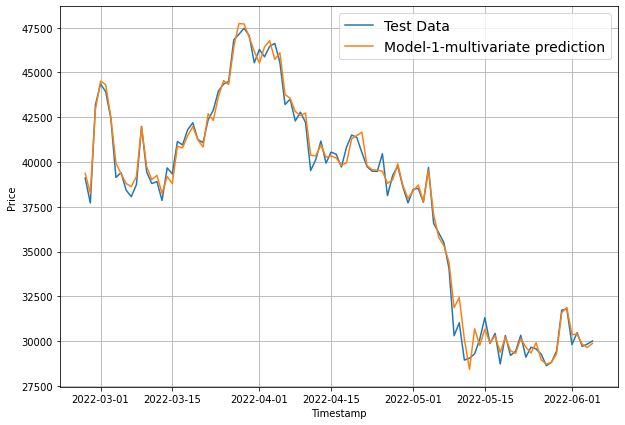

In [265]:
offset=len(x_test)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_test.index.to_numpy(), values=denormalize_price(y_test.to_numpy()), format="-", start=offset, label="Test Data")
plot_time_series(timesteps=x_test.index.to_numpy(), values=denormalize_price(model_1_multi_preds), format="-", start=offset, label="Model-1-multivariate prediction")

In [266]:
#  values=denormalize_price(model_1_multi_preds.numpy(), price_mem_multivariate)

In [267]:
# offset=len(test_windows)-100
# plt.figure(figsize=(10,7))
# plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
# plot_time_series(timesteps=x_test.index.to_numpy(), values=model_1_multi_preds.numpy(), format="-", start=offset, label="Model-lstm prediction")

In [268]:
model_1_multi_results = evaluate_preds(y_true=y_test, y_pred=model_1_multi_preds)
model_1_multi_results

{'mae': 0.122753195, 'mape': 1.3974898, 'mse': 0.027892621, 'rmse': 0.16701084}

In [269]:
# # Testing with random
# model_1_multi.predict(tf.expand_dims([402.092010,	441.557007,	396.196991,	450.995000,	402.152008,	398.821014,	408.903992,	394.795990,	424.440002,	457.334015], axis=0))


## Model_CONV1D_Multivariate

In [288]:
tf.random.set_seed(42)

# Create Conv1D model
model_2_multi = tf.keras.Sequential([

  layers.Lambda(lambda k: tf.expand_dims(k, axis=1)), # firstly adjust the size of our input data
  
  layers.Conv1D(filters=256, kernel_size=8, strides=1, padding="causal", activation="relu"),
  layers.BatchNormalization(),
  layers.Activation(activation='relu'),

  layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
  layers.BatchNormalization(),
  layers.Activation(activation='relu'),

  layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"),
  layers.BatchNormalization(),
  layers.Activation(activation='relu'),

  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation="relu"),

  layers.Dense(HORIZON, activation="relu")

], name="model_conv1D_multivariate")

# Compile model
model_2_multi.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
history_model_2_multi = model_2_multi.fit(x_train, #if faced data cardinality error, do tf.stack(train_windows) or np.array(train_windows)
            y_train, 
            batch_size=BATCH_SIZE, 
            epochs=1000, 
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[early_stopping()]
            )

Epoch 1/1000
36/36 [==============================] - 3s 20ms/step - loss: 0.6131 - val_loss: 8.4837
Epoch 2/1000
36/36 [==============================] - 0s 12ms/step - loss: 0.5342 - val_loss: 8.2827
Epoch 3/1000
36/36 [==============================] - 0s 11ms/step - loss: 0.5326 - val_loss: 7.8611
Epoch 4/1000
36/36 [==============================] - 0s 12ms/step - loss: 0.5187 - val_loss: 7.2934
Epoch 5/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.5202 - val_loss: 6.8767
Epoch 6/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5326 - val_loss: 5.7803
Epoch 7/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5167 - val_loss: 4.9128
Epoch 8/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5273 - val_loss: 4.2258
Epoch 9/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5072 - val_loss: 3.2545
Epoch 10/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5202 - val_loss: 2.

In [289]:
model_2_multi.evaluate(x_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 0.1512


0.15120723843574524

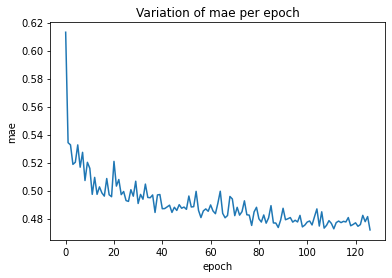

In [302]:
plt.plot(history_model_2_multi.history['loss'])
plt.title('Variation of mae per epoch')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

In [292]:
# Model predictions
model_2_multi_preds = make_prediction(model_2_multi, x_test)

In [293]:
# denormalize_price(y_test.to_numpy())

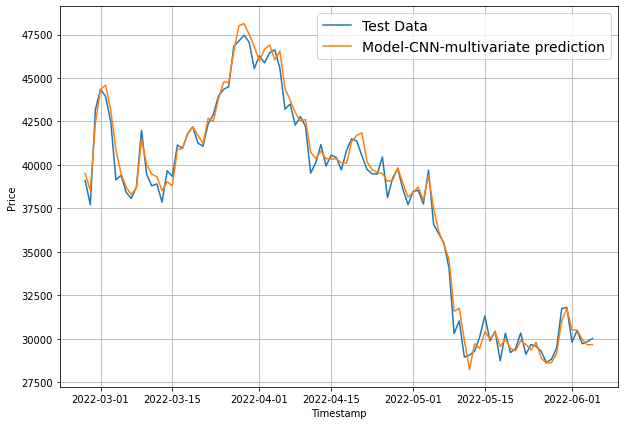

In [294]:
offset=len(x_test)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_test.index.to_numpy(), values=denormalize_price(y_test.to_numpy()), format="-", start=offset, label="Test Data")
plot_time_series(timesteps=x_test.index.to_numpy(), values=denormalize_price(model_2_multi_preds), format="-", start=offset, label="Model-CNN-multivariate prediction")


In [295]:
# Evaluate predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_2_multi_preds)
model_2_results

{'mae': 0.15120724, 'mape': 1.7466577, 'mse': 0.044288803, 'rmse': 0.21044905}

In [277]:
model_2_multi.summary()

Model: "model_conv1D_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_15 (Lambda)          (None, 1, 10)             0         
                                                                 
 conv1d_14 (Conv1D)          (None, 1, 256)            20736     
                                                                 
 batch_normalization_9 (Batc  (None, 1, 256)           1024      
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 1, 256)            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 1, 128)            163968    
                                                                 
 batch_normalization_10 (Bat  (None, 1, 128)           512       
 chNormalization)                        

## LSTM Multivariate Model

In [296]:
# See improving a model section of the bit-predict notebook
tf.random.set_seed(42)

# Make an LSTM model with the functional API
inputs=layers.Input(shape=x_train.shape[1])
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.Bidirectional(layers.LSTM(128, activation="relu"))(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_3_multi = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm_multivariate")

# Compile
model_3_multi.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
history_model_3_multi = model_3_multi.fit(x_train,
            y_train,
            epochs=1000,
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_data=(x_test, y_test),
            callbacks=[early_stopping()]
            )



Epoch 1/1000
36/36 [==============================] - 3s 20ms/step - loss: 0.3436 - val_loss: 2.4619
Epoch 2/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0441 - val_loss: 2.9619
Epoch 3/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0370 - val_loss: 1.6324
Epoch 4/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0346 - val_loss: 1.4458
Epoch 5/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0283 - val_loss: 1.2150
Epoch 6/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0262 - val_loss: 0.2569
Epoch 7/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0256 - val_loss: 0.4325
Epoch 8/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0255 - val_loss: 0.4102
Epoch 9/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0267 - val_loss: 0.3893
Epoch 10/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0301 - val_loss: 0.

In [298]:
model_3_multi.evaluate(x_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 0.1679


0.16785821318626404

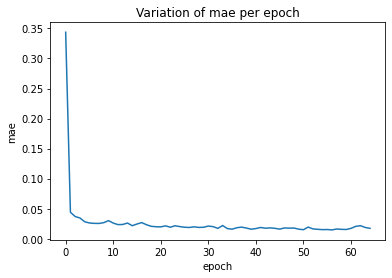

In [299]:
plt.plot(history_model_3_multi.history['loss'])
plt.title('Variation of mae per epoch')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

In [95]:
# Make predictions with our LSTM model
model_3_multi_preds = make_prediction(model_3_multi, x_test)

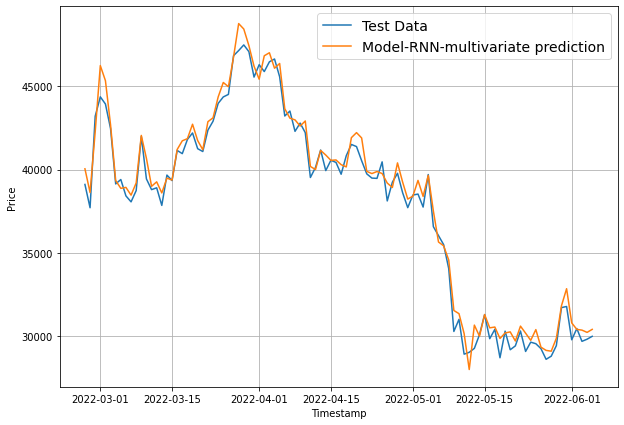

In [96]:
offset=len(x_test)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_test.index.to_numpy(), values=denormalize_price(y_test.to_numpy()), format="-", start=offset, label="Test Data")
plot_time_series(timesteps=x_test.index.to_numpy(), values=denormalize_price(model_3_multi_preds), format="-", start=offset, label="Model-RNN-multivariate prediction")

In [97]:
model_3_results_multi = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_3_multi_preds)
model_3_results_multi

{'mae': 0.16785833, 'mape': 1.9440969, 'mse': 0.049079936, 'rmse': 0.22153991}

In [98]:
# Testing with random
# model_3_multi.predict(tf.expand_dims([1,2,3,4,5,6,7,8,9,10,12,12], axis=0))

# Future Predictions

In [102]:
btc_df = btc_df_original_uni
btc_df

,Price
Timestamp,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2022-06-01,29799.080080
2022-06-02,30467.488280
2022-06-03,29704.390630


In [105]:
scaler_3 = StandardScaler()
btc_df_all = pd.DataFrame(scaler_3.fit_transform(btc_df), index = btc_df.index, columns = btc_df.columns)
btc_df_all

,Price
Timestamp,
2014-09-17,-0.713715
2014-09-18,-0.715693
2014-09-19,-0.717476
2014-09-20,-0.716627
2014-09-21,-0.717233
...,...
2022-06-01,1.050726
2022-06-02,1.090920
2022-06-03,1.045031


In [107]:
import math
def denormalize_future_price(result):
  final_price = []
  mean = scaler_3.mean_[0]
  std = math.sqrt(scaler_3.var_[0])
  for i in result:
    price_ = i * std + mean
    final_price.append(price_)
  return final_price

In [108]:
#  Windows the dataset directly from the pandas dataframe
btc_windowed_df = btc_df_all.copy() # copy is needed to avoid pandas warning

# Adds windowed columns
for i in range(WINDOW_SIZE):
  btc_windowed_df[f"Price+{i+1}"] = btc_windowed_df["Price"].shift(periods=i+1)
btc_windowed_df.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6
Timestamp,,,,,,,
2014-09-17,-0.713715,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,-0.715693,-0.713715,NaN,NaN,NaN,NaN,NaN
2014-09-19,-0.717476,-0.715693,-0.713715,NaN,NaN,NaN,NaN
2014-09-20,-0.716627,-0.717476,-0.715693,-0.713715,NaN,NaN,NaN
2014-09-21,-0.717233,-0.716627,-0.717476,-0.715693,-0.713715,NaN,NaN
2014-09-22,-0.717033,-0.717233,-0.716627,-0.717476,-0.715693,-0.713715,NaN
2014-09-23,-0.715010,-0.717033,-0.717233,-0.716627,-0.717476,-0.715693,-0.713715
2014-09-24,-0.715767,-0.715010,-0.717033,-0.717233,-0.716627,-0.717476,-0.715693
2014-09-25,-0.716467,-0.715767,-0.715010,-0.717033,-0.717233,-0.716627,-0.717476


In [109]:
# Removing the rows with the missing values
# Create X (windows) and Y (horizons) features
x = btc_windowed_df.dropna().drop("Price", axis=1).astype(np.float32) # windows
y = btc_windowed_df.dropna()["Price"].astype(np.float32) # labels
x.head(), y.head()

(             Price+1   Price+2   Price+3   Price+4   Price+5   Price+6
 Timestamp                                                             
 2014-09-23 -0.717033 -0.717233 -0.716627 -0.717476 -0.715693 -0.713715
 2014-09-24 -0.715010 -0.717033 -0.717233 -0.716627 -0.717476 -0.715693
 2014-09-25 -0.715767 -0.715010 -0.717033 -0.717233 -0.716627 -0.717476
 2014-09-26 -0.716467 -0.715767 -0.715010 -0.717033 -0.717233 -0.716627
 2014-09-27 -0.716897 -0.716467 -0.715767 -0.715010 -0.717033 -0.717233,
 Timestamp
 2014-09-23   -0.715010
 2014-09-24   -0.715767
 2014-09-25   -0.716467
 2014-09-26   -0.716897
 2014-09-27   -0.717191
 Name: Price, dtype: float32)

In [110]:
# Number of predictions into future
predictions_n = len(test_windows)

In [111]:
# In the function of predicting the future, there is no test sets
# Train model on entire data to make predictions for the next day
x_all = btc_windowed_df.dropna().drop(["Price"], axis=1).to_numpy()[:-predictions_n]

# Get labels
y_all = btc_windowed_df.dropna()["Price"][:-predictions_n]

len(x_all), len(y_all)

(2255, 2255)

In [136]:
x_all

array([[-0.71703319, -0.7172335 , -0.71662716, -0.71747554, -0.71569292,
        -0.71371487],
       [-0.71501034, -0.71703319, -0.7172335 , -0.71662716, -0.71747554,
        -0.71569292],
       [-0.71576719, -0.71501034, -0.71703319, -0.7172335 , -0.71662716,
        -0.71747554],
       ...,
       [ 0.37981819,  0.37856031,  0.33019896,  0.32941217,  0.31987492,
         0.26399257],
       [ 0.36344785,  0.37981819,  0.37856031,  0.33019896,  0.32941217,
         0.31987492],
       [ 0.36309421,  0.36344785,  0.37981819,  0.37856031,  0.33019896,
         0.32941217]])

In [137]:
y_all

Timestamp
2014-09-23   -0.715010
2014-09-24   -0.715767
2014-09-25   -0.716467
2014-09-26   -0.716897
2014-09-27   -0.717191
                ...   
2020-11-20    0.378560
2020-11-21    0.379818
2020-11-22    0.363448
2020-11-23    0.363094
2020-11-24    0.407795
Name: Price, Length: 2255, dtype: float64

In [112]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(x_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE=1024
# tf.data.AUTOTUNE automatically prefetches the data on CPU as best as it can
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [138]:
""" 
  Future-Model-1: Dense model (window=7, horizon=1)
"""

# Set random seed for as reprodicible results as possible
tf.random.set_seed(42)

future_model_1 = tf.keras.Sequential([
  layers.Dense(128, activation='relu'),
  layers.Dense(HORIZON, activation='relu')
], name='future_pred_model') # we can use it for our checkpoint function

# 2. Compile
future_model_1.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["mae", "mse"])

# 3. Fit the model
future_model_1.fit(x_all,
            y_all,
            epochs=300,
            verbose=1, # it refers to how much information we want to print for our models
            batch_size=BATCH_SIZE,
            )



Epoch 1/300
3/3 [==============================] - 1s 12ms/step - loss: 0.7230 - mae: 0.7230 - mse: 0.6644
Epoch 2/300
3/3 [==============================] - 0s 5ms/step - loss: 0.6149 - mae: 0.6149 - mse: 0.4879
Epoch 3/300
3/3 [==============================] - 0s 6ms/step - loss: 0.5133 - mae: 0.5133 - mse: 0.3414
Epoch 4/300
3/3 [==============================] - 0s 8ms/step - loss: 0.4687 - mae: 0.4687 - mse: 0.2791
Epoch 5/300
3/3 [==============================] - 0s 10ms/step - loss: 0.4685 - mae: 0.4685 - mse: 0.2791
Epoch 6/300
3/3 [==============================] - 0s 6ms/step - loss: 0.4686 - mae: 0.4686 - mse: 0.2791
Epoch 7/300
3/3 [==============================] - 0s 6ms/step - loss: 0.4687 - mae: 0.4687 - mse: 0.2791
Epoch 8/300
3/3 [==============================] - 0s 8ms/step - loss: 0.4688 - mae: 0.4688 - mse: 0.2791
Epoch 9/300
3/3 [==============================] - 0s 6ms/step - loss: 0.4686 - mae: 0.4686 - mse: 0.2791
Epoch 10/300
3/3 [==========================

In [139]:
# Need to think of an way for this multi-variate model

In [140]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts for into_future steps after values ends.
  Returns future forecasts as a list of floats.
  """
  
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for i in range(into_future):
    # Model will eventually make future forecasts based on its past forecasts.
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    # print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds 
    # provided that model was trained on WINDOW_SIZE window
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecast

In [141]:
# Make forecasts into the future
future_forecast_1 = make_future_forecasts(values=y_all,
                                        model=future_model_1,
                                        into_future=predictions_n,
                                        window_size=WINDOW_SIZE)

In [142]:
# len(future_forecast_1), predictions_n

In [143]:
timestamps = btc_windowed_df.tail(predictions_n).index.to_numpy()
prices = btc_windowed_df.tail(predictions_n)['Price'].to_numpy()

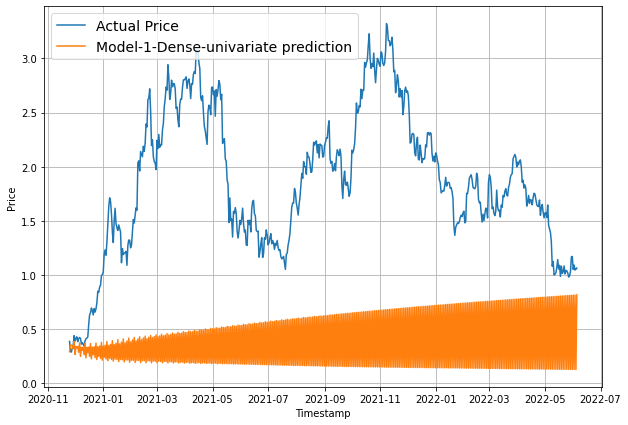

In [144]:
offset=0
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timestamps, values=prices, format="-", start=offset, label="Actual Price")
plot_time_series(timesteps=timestamps, values=future_forecast_1, format="-", start=offset, label="Model-1-Dense-univariate prediction")

## Future Model-2

In [155]:
tf.random.set_seed(42)

# Create Conv1D model
future_model_2 = tf.keras.Sequential([

  layers.Lambda(lambda k: tf.expand_dims(k, axis=1)), # firstly adjust the size of our input data
  
  layers.Conv1D(filters=256, kernel_size=8, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  # layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  # layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  layers.GlobalAveragePooling1D(),
  layers.Dense(HORIZON, activation="relu")

], name="model_conv1D")

# Compile model
future_model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
future_model_2.fit(x_all,
                  y_all, 
                  epochs=200, 
                  verbose=1,
                  batch_size=BATCH_SIZE, 
                  )

Epoch 1/200
3/3 [==============================] - 1s 9ms/step - loss: 0.4960
Epoch 2/200
3/3 [==============================] - 0s 8ms/step - loss: 0.4709
Epoch 3/200
3/3 [==============================] - 0s 7ms/step - loss: 0.4699
Epoch 4/200
3/3 [==============================] - 0s 7ms/step - loss: 0.4692
Epoch 5/200
3/3 [==============================] - 0s 7ms/step - loss: 0.4688
Epoch 6/200
3/3 [==============================] - 0s 9ms/step - loss: 0.4688
Epoch 7/200
3/3 [==============================] - 0s 10ms/step - loss: 0.4689
Epoch 8/200
3/3 [==============================] - 0s 5ms/step - loss: 0.4690
Epoch 9/200
3/3 [==============================] - 0s 6ms/step - loss: 0.4689
Epoch 10/200
3/3 [==============================] - 0s 8ms/step - loss: 0.4687
Epoch 11/200
3/3 [==============================] - 0s 10ms/step - loss: 0.4686
Epoch 12/200
3/3 [==============================] - 0s 5ms/step - loss: 0.4686
Epoch 13/200
3/3 [==============================] - 0s 6ms/

In [156]:
# for i in dataset_all:
#   print(i)

In [157]:
# Make forecasts into the future
future_forecast_2 = make_future_forecasts(values=y_all,
                                        model=future_model_2,
                                        into_future=predictions_n,
                                        window_size=WINDOW_SIZE)

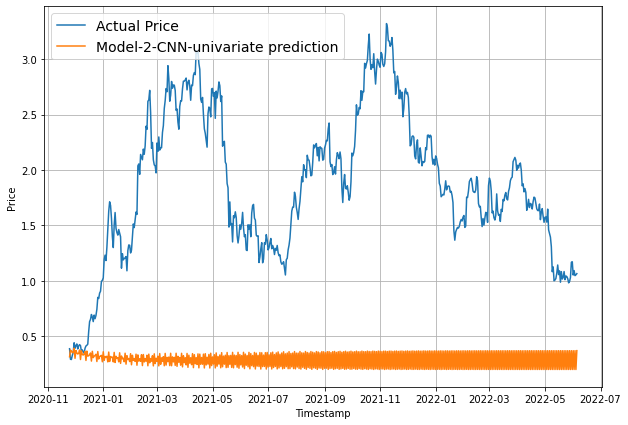

In [161]:
offset=0
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timestamps, values=prices, format="-", start=offset, label="Actual Price")
plot_time_series(timesteps=timestamps, values=future_forecast_2, format="-", start=offset, label="Model-2-CNN-univariate prediction")

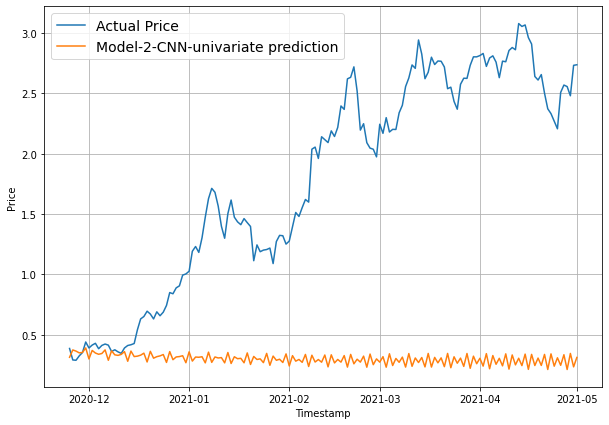

In [170]:
offset=0
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timestamps[:-400], values=prices[:-400], format="-", start=offset, label="Actual Price")
plot_time_series(timesteps=timestamps[:-400], values=future_forecast_2[:-400], format="-", start=offset, label="Model-2-CNN-univariate prediction")

## Future Model-3

In [162]:
# See improving a model section of the bit-predict notebook
tf.random.set_seed(42)

# Make an LSTM model with the functional API
inputs=layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x) # to create more than 1 hidden layer
x = layers.Bidirectional(layers.LSTM(128, activation="relu"))(x)
# x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
future_model_3 = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

# Compile
future_model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
future_model_3.fit(x_all,
            y_all,
            epochs=300,
            verbose=1,
            batch_size=BATCH_SIZE,
            )



Epoch 1/300
3/3 [==============================] - 3s 22ms/step - loss: 0.4565
Epoch 2/300
3/3 [==============================] - 0s 30ms/step - loss: 0.4045
Epoch 3/300
3/3 [==============================] - 0s 15ms/step - loss: 0.3542
Epoch 4/300
3/3 [==============================] - 0s 21ms/step - loss: 0.3000
Epoch 5/300
3/3 [==============================] - 0s 19ms/step - loss: 0.2407
Epoch 6/300
3/3 [==============================] - 0s 12ms/step - loss: 0.1762
Epoch 7/300
3/3 [==============================] - 0s 12ms/step - loss: 0.1108
Epoch 8/300
3/3 [==============================] - 0s 20ms/step - loss: 0.0555
Epoch 9/300
3/3 [==============================] - 0s 29ms/step - loss: 0.0598
Epoch 10/300
3/3 [==============================] - 0s 31ms/step - loss: 0.0394
Epoch 11/300
3/3 [==============================] - 0s 22ms/step - loss: 0.0402
Epoch 12/300
3/3 [==============================] - 0s 30ms/step - loss: 0.0342
Epoch 13/300
3/3 [==============================]

In [163]:
# Make forecasts into the future
future_forecast_3 = make_future_forecasts(values=y_all,
                                        model=future_model_3,
                                        into_future=predictions_n,
                                        window_size=WINDOW_SIZE)

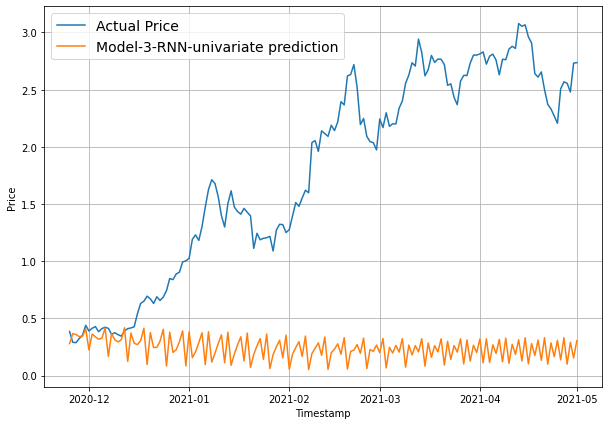

In [172]:
offset=0
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timestamps[:-400], values=prices[:-400], format="-", start=offset, label="Actual Price")
plot_time_series(timesteps=timestamps[:-400], values=future_forecast_3[:-400], format="-", start=offset, label="Model-3-RNN-univariate prediction")

In [ ]:
!nvidia-smi